# **Creating our Sign Language Detection Model**

I will be creating the model in this notebook. The goal is to prepare the data so that it is well-suited for the model to train on, and to choose an appropriate training technique to ensure accurate sign detection

## **Image Data Preprocessing and Serialization**

gonna be using Google Mediapipe to detect hands in each of the images
this will get all the x and y landmarks for each image (21 landmarks for x, 21 for y), and map these landmarks to its corresponding label (letter/phrase). It will save this data in a pickle file and we will use this data to train the classification model

In [73]:
import os
import pickle

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt

In [74]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

hands =  mp_hands.Hands(static_image_mode=True,
                        max_num_hands=2,
                        min_detection_confidence=0.3)

images_folder = "./images"

data = [] # gonna store a series of x, y landmark points
labels = [] # gonna store a series of labels

expected_length = 21 * 2 # each image should have 42 features, 21 landmarks * 2 coordinates

I0000 00:00:1723875879.070979 2206554 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-22.5.10), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine (1x6x8 (fused) LP


**let's see if mediapipe is correctly able to detect my hands by displaying 1 image with the mediapipe hand connections being displayed**

W0000 00:00:1723875879.127397 2339213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1723875879.194236 2339213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


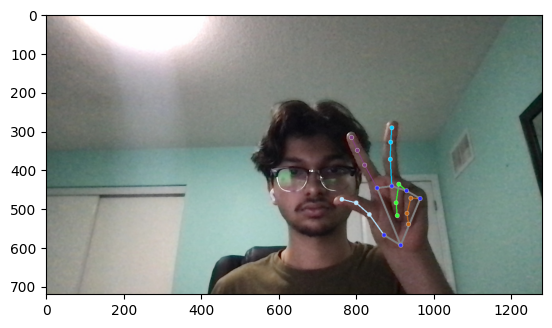

In [75]:
count = 0

for phrase in os.listdir(images_folder):
    for image_path in os.listdir(os.path.join(images_folder, phrase)):
        image = cv2.imread(os.path.join(images_folder, phrase, image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS, mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
        plt.figure()
        plt.imshow(image_rgb)
        count += 1
        if count == 1:
            break
    if count == 1:
        break

plt.show()

**as we can see, mediapipe is able to detect all landmarks. now we can iterate through each image, add the list of x and y coordinates to our overarching data list (features), and label these coordinates with the corresponding letter/phrase (labels)**

In [76]:
if not os.path.exists("image_data.pickle"):
    for phrase in os.listdir(images_folder):
        for image_path in os.listdir(os.path.join(images_folder, phrase)):
            image = cv2.imread(os.path.join(images_folder, phrase, image_path))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
            image_data = []
            image_x_values = []
            image_y_values = []
    
            results = hands.process(image_rgb)
    
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    image_x_values = [landmark.x for landmark in hand_landmarks.landmark]
                    image_y_values = [landmark.y for landmark in hand_landmarks.landmark]
    
                    for i in range(len(hand_landmarks.landmark)):
                        image_data.append(image_x_values[i] - min(image_x_values))
                        image_data.append(image_y_values[i] - min(image_y_values))
                if (len(image_data) == expected_length):
                    data.append(image_data)
                    labels.append(phrase)
    
    data_file = open("image_data.pickle", "wb")
    pickle.dump({"data": data, 'labels': labels}, data_file)
    data_file.close()

else:
    print("Serialized data already created")

Serialized data already created


## **Training our Image Classification Model**

we will train a neural network model to classify images using TensorFlow. by using TensorFlow, we ensure that the model can be exported and used in our web app with TensorFlow.js. A neural network is suitable for this because they are good at recognizing complex patterns and relationships in data, so it will be able to effectively learn and distinguish between different hand shapes and movements. Also neural networks generalize well to unseen data which is important for recognizing a variety of hand gestures in different conditions

In [77]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle

In [78]:
data_dict = pickle.load(open("./image_data.pickle", "rb"))

data = np.asarray(data_dict["data"])
labels = np.asarray(data_dict["labels"])

x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, shuffle=True, stratify=labels) # splitting train and test data

In [79]:
# converting the string labels into integer values. we have to do this because neural networks work with numerical data

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# neural networks perform better with one-hot encoded labels, so we should covert the integer labels into a binary matrix where each column 
# represents a letter/phrase

num_classes = len(np.unique(y_train))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

**here is some info about the neural network**
1. the input layer takes the feature vectors
2. the network has two layers with 128 and 64 nodes (neurons) each and uses ReLU activation to help it learn complex patterns better
3. the output layer has as many nodes as there are letters/phrases and it uses a softmax activation function to give the probability of each phrase being the correct one

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(num_classes, activation = "softmax")
])

# compiling model with the Adam optimizer, loss function to measure errors, accuracy to measure performance
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.fit(x_train, y_train, epochs = 25, batch_size = 32, validation_data = (x_test, y_test))

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)

score = accuracy_score(y_true_classes, y_pred_classes)
print(f"{score * 100}% of test sign language data was correctly classified")

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1046 - loss: 3.0486 - val_accuracy: 0.3438 - val_loss: 2.8335
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3907 - loss: 2.7247 - val_accuracy: 0.4987 - val_loss: 2.2486
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5262 - loss: 2.0605 - val_accuracy: 0.7480 - val_loss: 1.5047
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7690 - loss: 1.3498 - val_accuracy: 0.8504 - val_loss: 0.9948
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8417 - loss: 0.9221 - val_accuracy: 0.8661 - val_loss: 0.7193
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8801 - loss: 0.6703 - val_accuracy: 0.8950 - val_loss: 0.5612
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9070 - loss: 0.5388 - val_accuracy: 0.9423 - val_loss: 0.4610
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9218 - loss: 0.4531 - val_accuracy: 0.9265 - val_loss: 0.4081
Ep

**As we can see, the model performed well with 97.11% accuracy on the test data, which is good enough for our use case. I experimented with different epoch values (passes through the training dataset) and found that 25 epochs worked well without overfitting the model**

In [85]:
# saving the model as an .h5 so that it can be used on our frontend

model.save("sign_language_model.h5")